In [124]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


In [1]:
import pandas as pd

df = pd.read_csv("datasets/IBM_2006-01-01_to_2018-01-01.csv")

In [3]:
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
1,2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2,2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
3,2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
4,2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3020 entries, 0 to 3019
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3020 non-null   object 
 1   Open    3019 non-null   float64
 2   High    3020 non-null   float64
 3   Low     3019 non-null   float64
 4   Close   3020 non-null   float64
 5   Volume  3020 non-null   int64  
 6   Name    3020 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 165.3+ KB


In [128]:
df.isna().sum()

Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64

In [129]:
df = df.dropna()

In [130]:
df.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,145.515545,146.682319,144.471597,145.617592,5.773770e+06
std,37.554946,37.619664,37.477641,37.535600,3.193255e+06
min,72.740000,73.940000,69.500000,71.740000,2.542560e+05
25%,116.405000,117.750000,115.490000,116.520000,3.622178e+06
50%,149.610000,150.410000,148.470000,149.330000,4.931203e+06
75%,178.445000,179.775000,177.330000,178.690000,6.966642e+06
max,215.380000,215.900000,214.300000,215.800000,3.077428e+07


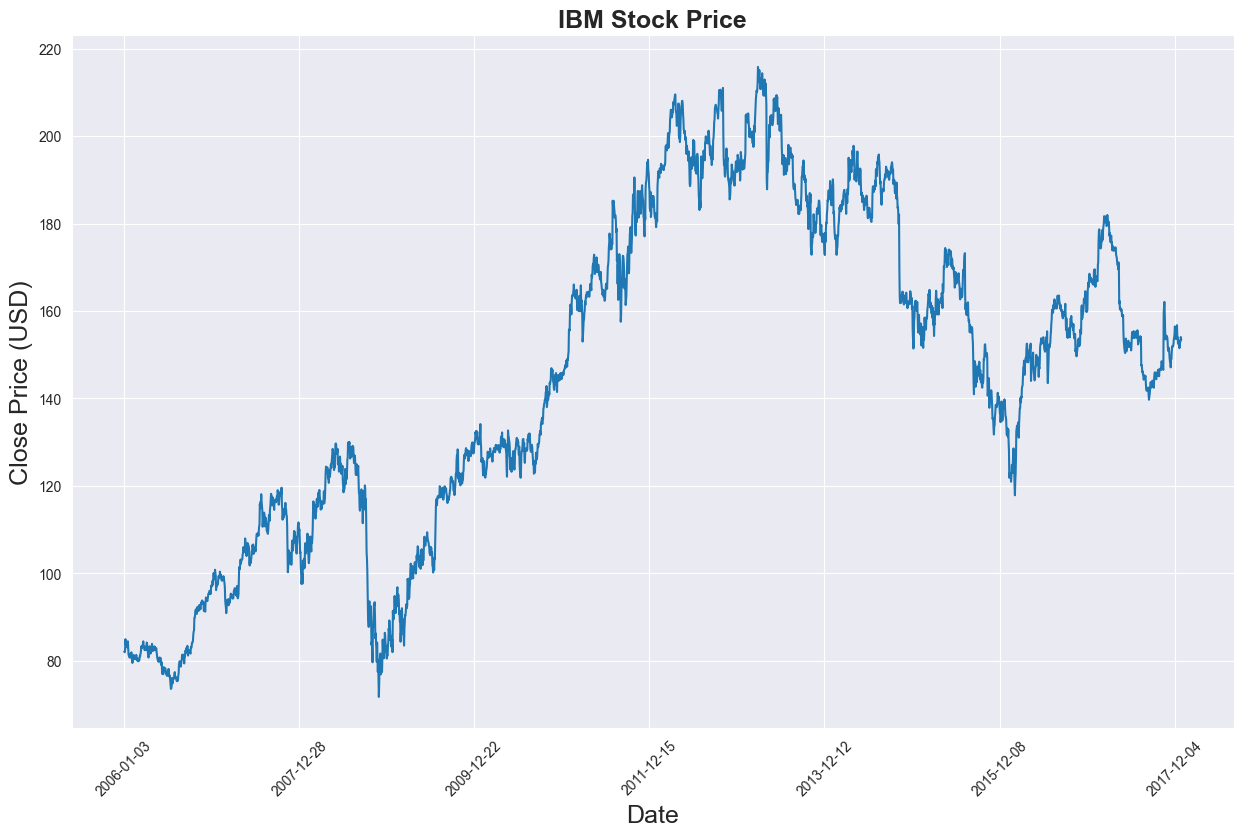

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (15,9))
plt.plot(df[['Close']])
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.title("IBM Stock Price",fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [132]:


# Check if CUDA (GPU) is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [133]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [134]:
data = df[['Open', 'High', 'Low', 'Volume']]
target = df[['Close']]

# Normalize data
scaler_x = MinMaxScaler()
data_scaled = scaler_x.fit_transform(data)

scaler_y = MinMaxScaler()
target_scaled = scaler_y.fit_transform(target)

In [135]:
# Combine scaled features with the target Close price for data splitting
data_scaled = np.hstack((data_scaled, target_scaled))

In [136]:
data.head()

,Open,High,Low,Volume
0,82.45,82.55,80.81,11715200
1,82.20,82.50,81.33,9840600
2,81.40,82.90,81.00,7213500
3,83.95,85.03,83.41,8197400
4,84.10,84.25,83.38,6858200


### Prepare data

### Multivaiate 

In [137]:
# Dataset class
class StockDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len, :] # Exclude target (Close)
        # Target: The 'close' value at the next time step
        y = self.data[idx + self.seq_len, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
   

In [138]:
# Split data
seq_len = 20 # Lookback
train_size = int(len(data_scaled) * 0.8)
valid_size = int(len(data_scaled) * 0.1)
test_size = len(data_scaled) - train_size - valid_size

train_data = data_scaled[:train_size]
valid_data = data_scaled[train_size:train_size + valid_size]
test_data = data_scaled[train_size + valid_size:]

In [139]:
# Prepare for multivariate prediction
train_dataset = StockDataset(train_data, seq_len)
valid_dataset = StockDataset(valid_data, seq_len)
test_dataset = StockDataset(test_data, seq_len)

# Call set_seed to ensure reproducibility
set_seed(42)

# Create a generator for shuffling with the same seed
generator = torch.Generator().manual_seed(42)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [140]:
class VanillaRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(VanillaRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

### Univariate RNNs


In [150]:
class StockDatasetSingle(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        # Input: Sequence of `close` values
        x = self.data[idx:idx + self.seq_len, -1].reshape(-1, 1)  # Only the 'close' column
        # Target: The next `close` value
        y = self.data[idx + self.seq_len, -1]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [151]:
train_dataset_single = StockDatasetSingle(train_data, seq_len)
valid_dataset_single = StockDatasetSingle(valid_data, seq_len)
test_dataset_single = StockDatasetSingle(test_data, seq_len)

train_loader_single = DataLoader(train_dataset_single, batch_size=64, shuffle=True, generator=generator)
valid_loader_single = DataLoader(valid_dataset_single, batch_size=64, shuffle=False)
test_loader_single = DataLoader(test_dataset_single, batch_size=64, shuffle=False)

### Training and Prediction

In [141]:
def train_and_evaluate(model, train_loader, valid_loader, device, epochs=100):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    rmse = 0

    set_seed(42)
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(x_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        valid_loss = 0
        y_preds, y_trues = [], []
        with torch.no_grad():
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_pred = model(x_batch).squeeze()
                loss = criterion(y_pred, y_batch)
                valid_loss += loss.item()
                y_preds.extend(y_pred.cpu().numpy())
                y_trues.extend(y_batch.cpu().numpy())

        # Inverse transform predictions and true values to original scale
        y_preds_original = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1)).flatten()
        y_trues_original = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1)).flatten()

        valid_loss /= len(valid_loader)
        # Calculate RMSE on original scale
        rmse = np.sqrt(mean_squared_error(y_trues_original, y_preds_original))

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, RMSE: {rmse}")

    return model, rmse

In [142]:
import matplotlib.pyplot as plt

def plot_predictions(model, data_loader, device, title="Predictions vs Actual"):
    model.eval()
    y_preds, y_trues = [], []
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch).squeeze()
            y_preds.extend(y_pred.cpu().numpy())
            y_trues.extend(y_batch.cpu().numpy())

    # Inverse transform predictions and true values to original scale
    y_preds_original = scaler_y.inverse_transform(np.array(y_preds).reshape(-1, 1)).flatten()
    y_trues_original = scaler_y.inverse_transform(np.array(y_trues).reshape(-1, 1)).flatten()

    # Calculate final loss and RMSE
    final_mse_loss = np.mean((y_trues_original-y_preds_original)**2)
    final_rmse = np.sqrt(final_mse_loss)

    print(f"Final Loss: {final_mse_loss}, Final RMSE: {final_rmse}")

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(y_trues_original, label="Actual", color="blue", linewidth=2)
    plt.plot(y_preds_original, label="Predicted", color="orange", linestyle="--", linewidth=2)
    plt.title(title)
    plt.xlabel("Sample Index")
    plt.ylabel("Close Price")
    plt.legend()
    plt.grid(True)
    plt.show()

### Multivariable prediction

In [143]:
# Main script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 5 # Multivarible
hidden_dim = 64

In [144]:
print("Vanilla RNN:")
rnn_model_multi = VanillaRNN(input_dim, hidden_dim)
rnn_model_multi, rnn_model_multi_rmse = train_and_evaluate(rnn_model_multi, train_loader, valid_loader, device)

Vanilla RNN:
Epoch 1/100, Train Loss: 0.02964201277599817, Valid Loss: 0.0005970963567961008, RMSE: 3.6907012462615967
Epoch 2/100, Train Loss: 0.0005743548804036292, Valid Loss: 0.0004280861408915371, RMSE: 3.001934289932251
Epoch 3/100, Train Loss: 0.0003589254740386662, Valid Loss: 0.00041068446589633825, RMSE: 2.951308488845825
Epoch 4/100, Train Loss: 0.0003444484402854486, Valid Loss: 0.0004023940535262227, RMSE: 2.9266176223754883
Epoch 5/100, Train Loss: 0.00034043416005596027, Valid Loss: 0.0003047193546080962, RMSE: 2.577437162399292
Epoch 6/100, Train Loss: 0.0003332301275804639, Valid Loss: 0.0003540767473168671, RMSE: 2.752500295639038
Epoch 7/100, Train Loss: 0.00032135960760857225, Valid Loss: 0.00041232036892324686, RMSE: 2.9544405937194824
Epoch 8/100, Train Loss: 0.00031636962529247334, Valid Loss: 0.0002952281094621867, RMSE: 2.5400919914245605
Epoch 9/100, Train Loss: 0.0003104492053879719, Valid Loss: 0.00026643482269719245, RMSE: 2.4260921478271484
Epoch 10/100, T

Final Loss: 4.132847785949707, Final RMSE: 2.032940626144409


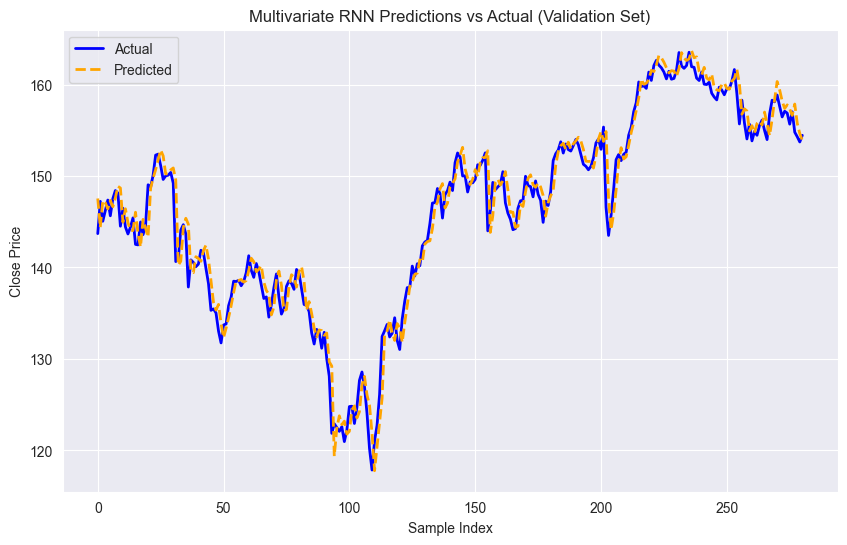

In [145]:
plot_predictions(rnn_model_multi, valid_loader, device, title="Multivariate RNN Predictions vs Actual (Validation Set)")

In [146]:
print("\nLSTM:")
lstm_model_multi = LSTM(input_dim=input_dim, hidden_dim=hidden_dim)
lstm_model_multi, lstm_model_multi_rmse = train_and_evaluate(lstm_model_multi, train_loader, valid_loader, device)


LSTM:
Epoch 1/100, Train Loss: 0.06256738833249792, Valid Loss: 0.0028015736024826765, RMSE: 7.835964679718018
Epoch 2/100, Train Loss: 0.003351457754002982, Valid Loss: 0.0019988293293863534, RMSE: 6.640227317810059
Epoch 3/100, Train Loss: 0.001104072208124164, Valid Loss: 0.0005161841458175331, RMSE: 3.4093198776245117
Epoch 4/100, Train Loss: 0.0007028765402011279, Valid Loss: 0.0004974795854650437, RMSE: 3.2622010707855225
Epoch 5/100, Train Loss: 0.0005762143218338391, Valid Loss: 0.0005080242524854838, RMSE: 3.2857980728149414
Epoch 6/100, Train Loss: 0.000557425827106559, Valid Loss: 0.0005884840094950051, RMSE: 3.4907338619232178
Epoch 7/100, Train Loss: 0.0005418978046356259, Valid Loss: 0.0004676656739320606, RMSE: 3.1775245666503906
Epoch 8/100, Train Loss: 0.0005343405255667964, Valid Loss: 0.000467227038461715, RMSE: 3.1704001426696777
Epoch 9/100, Train Loss: 0.0005126045967029457, Valid Loss: 0.0004384817788377404, RMSE: 3.0957298278808594
Epoch 10/100, Train Loss: 0.0

Final Loss: 4.734908103942871, Final RMSE: 2.1759843826293945


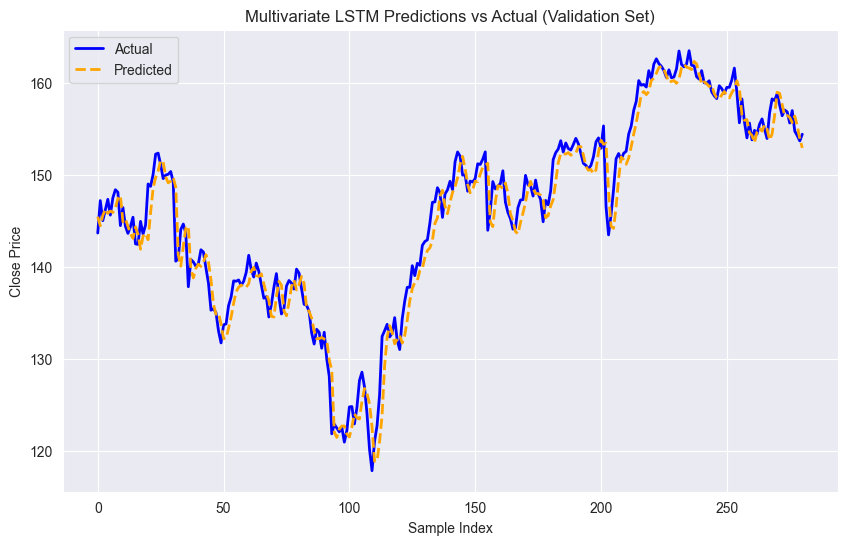

In [147]:
plot_predictions(lstm_model_multi, valid_loader, device, title="Multivariate LSTM Predictions vs Actual (Validation Set)")

In [148]:
print("\nGRU:")
gru_model_multi = GRU(input_dim=input_dim, hidden_dim=hidden_dim)
gru_model_multi, gru_model_multi_rmse = train_and_evaluate(gru_model_multi, train_loader, valid_loader, device)


GRU:
Epoch 1/100, Train Loss: 0.06927936168779668, Valid Loss: 0.0015267760842107236, RMSE: 5.528921127319336
Epoch 2/100, Train Loss: 0.0017801173878404753, Valid Loss: 0.0004984874918591231, RMSE: 3.201367139816284
Epoch 3/100, Train Loss: 0.0003863317121469759, Valid Loss: 0.00035836650058627126, RMSE: 2.7681705951690674
Epoch 4/100, Train Loss: 0.0003507298323184889, Valid Loss: 0.0003149568423395976, RMSE: 2.614727735519409
Epoch 5/100, Train Loss: 0.00033541106332497865, Valid Loss: 0.0003118638036539778, RMSE: 2.595784902572632
Epoch 6/100, Train Loss: 0.0003204030493323348, Valid Loss: 0.00033458417747169735, RMSE: 2.6688287258148193
Epoch 7/100, Train Loss: 0.00031829738566700955, Valid Loss: 0.0002747691381955519, RMSE: 2.458254337310791
Epoch 8/100, Train Loss: 0.00030704791501385013, Valid Loss: 0.00027273580490145833, RMSE: 2.4463629722595215
Epoch 9/100, Train Loss: 0.00030273718201849416, Valid Loss: 0.0002789371821563691, RMSE: 2.4621098041534424
Epoch 10/100, Train Lo

Final Loss: 4.064096927642822, Final RMSE: 2.015960454940796


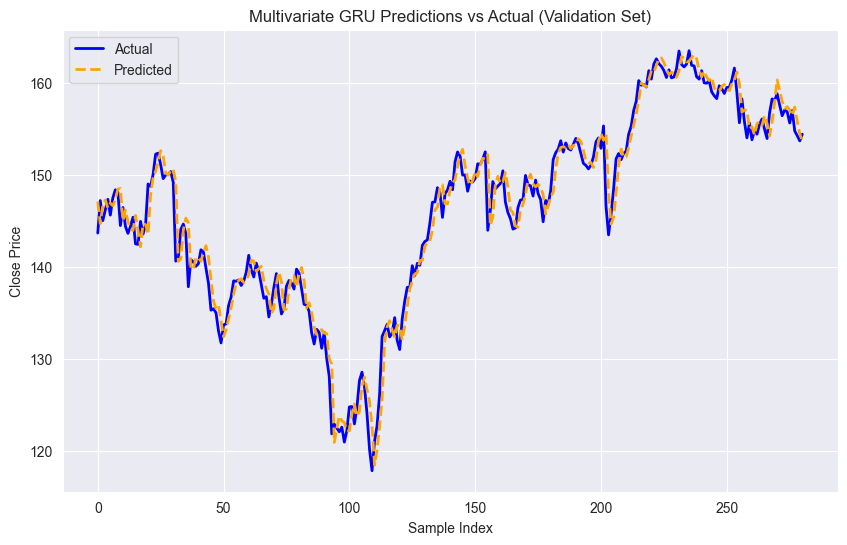

In [149]:
# Plot predictions for the validation set
plot_predictions(gru_model_multi, valid_loader, device, title="Multivariate GRU Predictions vs Actual (Validation Set)")

### Univariate Prediction

In [152]:
# Main script
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = 1
hidden_dim = 50

In [153]:
print("Vanilla RNN:")
rnn_model = VanillaRNN(input_dim, hidden_dim)
rnn_model, rnn_rmse = train_and_evaluate(rnn_model, train_loader_single, valid_loader_single, device)

Vanilla RNN:
Epoch 1/100, Train Loss: 0.15600823071834288, Valid Loss: 0.004636538913473487, RMSE: 9.368237495422363
Epoch 2/100, Train Loss: 0.01645334541344231, Valid Loss: 0.0004732965782750398, RMSE: 3.1511390209198
Epoch 3/100, Train Loss: 0.0008201848295835876, Valid Loss: 0.0005406871205195785, RMSE: 3.371507167816162
Epoch 4/100, Train Loss: 0.00044467063746292536, Valid Loss: 0.00044993464252911507, RMSE: 3.1079013347625732
Epoch 5/100, Train Loss: 0.00043374603372189755, Valid Loss: 0.0004147906496655196, RMSE: 2.9919137954711914
Epoch 6/100, Train Loss: 0.0004167408467190781, Valid Loss: 0.0004160248616244644, RMSE: 2.9931538105010986
Epoch 7/100, Train Loss: 0.0004197110515394199, Valid Loss: 0.0005155146296601743, RMSE: 3.310924768447876
Epoch 8/100, Train Loss: 0.00039414989020626406, Valid Loss: 0.00035070060403086245, RMSE: 2.7764487266540527
Epoch 9/100, Train Loss: 0.00039093709959783345, Valid Loss: 0.0004172682820353657, RMSE: 3.0026283264160156
Epoch 10/100, Train 

Final Loss: 5.0772929191589355, Final RMSE: 2.2532849311828613


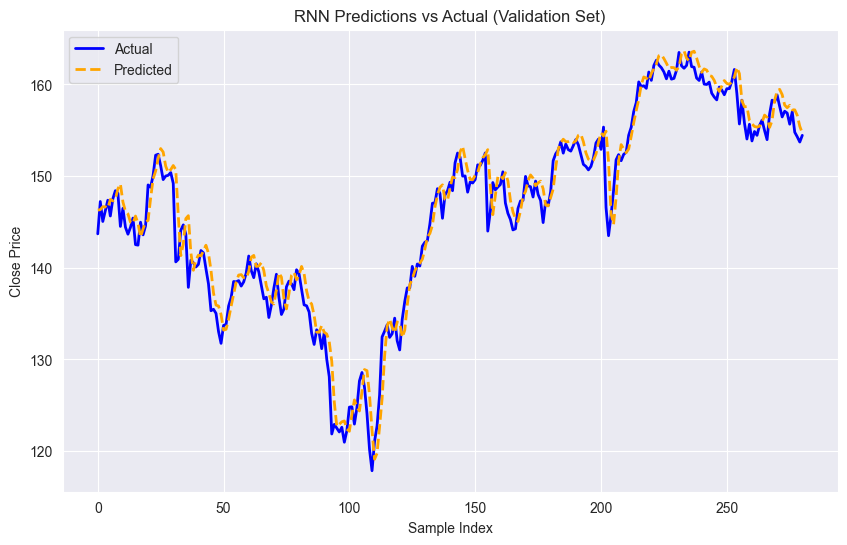

In [154]:
plot_predictions(rnn_model, valid_loader_single, device, title="RNN Predictions vs Actual (Validation Set)")

In [155]:
print("\nLSTM:")
lstm_model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim)
lstm_model, lstm_rmse = train_and_evaluate(lstm_model, train_loader_single, valid_loader_single, device)


LSTM:
Epoch 1/100, Train Loss: 0.10298068370474012, Valid Loss: 0.003997168131172657, RMSE: 8.803977966308594
Epoch 2/100, Train Loss: 0.016522323565655632, Valid Loss: 0.004075928032398224, RMSE: 9.328520774841309
Epoch 3/100, Train Loss: 0.0031790274875483624, Valid Loss: 0.0019565796479582786, RMSE: 6.544348239898682
Epoch 4/100, Train Loss: 0.0016625926548026893, Valid Loss: 0.0010804279881995171, RMSE: 4.96028470993042
Epoch 5/100, Train Loss: 0.0008857661986870593, Valid Loss: 0.0006523022369947284, RMSE: 3.82775616645813
Epoch 6/100, Train Loss: 0.0007455756713170558, Valid Loss: 0.0007174952886998653, RMSE: 3.9113152027130127
Epoch 7/100, Train Loss: 0.0007206254093417604, Valid Loss: 0.0006223303265869617, RMSE: 3.699991226196289
Epoch 8/100, Train Loss: 0.0006880666271746648, Valid Loss: 0.0006165747647173703, RMSE: 3.678299903869629
Epoch 9/100, Train Loss: 0.0007106455059807846, Valid Loss: 0.0005958958470728248, RMSE: 3.682204246520996
Epoch 10/100, Train Loss: 0.00067583

Final Loss: 5.157708168029785, Final RMSE: 2.2710587978363037


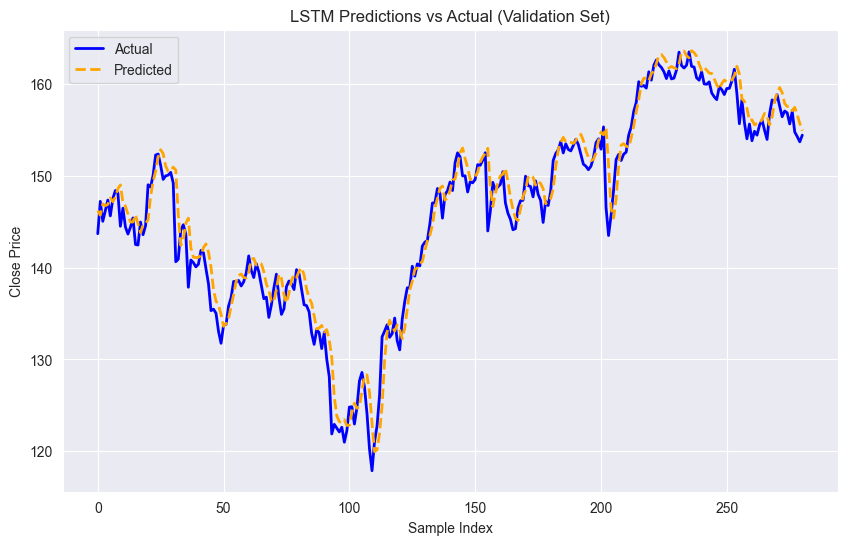

In [156]:
plot_predictions(lstm_model, valid_loader_single, device, title="LSTM Predictions vs Actual (Validation Set)")

In [157]:
print("\nGRU:")
gru_model = GRU(input_dim=input_dim, hidden_dim=hidden_dim)
gru_model, gru_rmse = train_and_evaluate(gru_model, train_loader_single, valid_loader_single, device)


GRU:
Epoch 1/100, Train Loss: 0.17137972912506053, Valid Loss: 0.0061637759092263876, RMSE: 11.99893569946289
Epoch 2/100, Train Loss: 0.026755309933306354, Valid Loss: 0.0010941712243948132, RMSE: 5.0434651374816895
Epoch 3/100, Train Loss: 0.002775339971872439, Valid Loss: 0.0006955578195629641, RMSE: 3.976013660430908
Epoch 4/100, Train Loss: 0.0006332620649022589, Valid Loss: 0.0005238519195700064, RMSE: 3.445794105529785
Epoch 5/100, Train Loss: 0.0005392178733784117, Valid Loss: 0.00041563755366951226, RMSE: 3.0561037063598633
Epoch 6/100, Train Loss: 0.0005130942024008714, Valid Loss: 0.00044229390041437, RMSE: 3.1627979278564453
Epoch 7/100, Train Loss: 0.00045756407091271525, Valid Loss: 0.00037351248029153793, RMSE: 2.876110076904297
Epoch 8/100, Train Loss: 0.00042441956266932383, Valid Loss: 0.00037146477261558176, RMSE: 2.890561580657959
Epoch 9/100, Train Loss: 0.0004298370944238023, Valid Loss: 0.00035157820966560396, RMSE: 2.805925130844116
Epoch 10/100, Train Loss: 0.

Final Loss: 4.893188953399658, Final RMSE: 2.2120554447174072


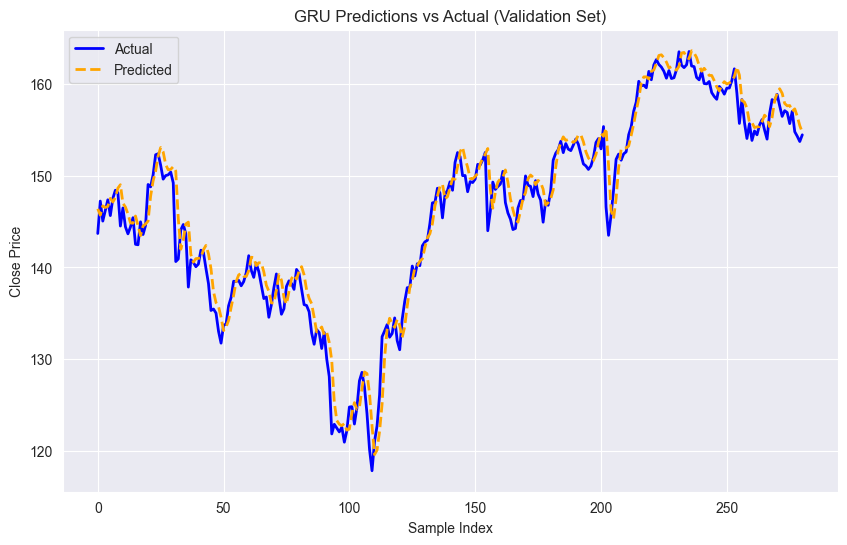

In [158]:
# Plot predictions for the validation set
plot_predictions(gru_model, valid_loader_single, device, title="GRU Predictions vs Actual (Validation Set)")

### Comparison

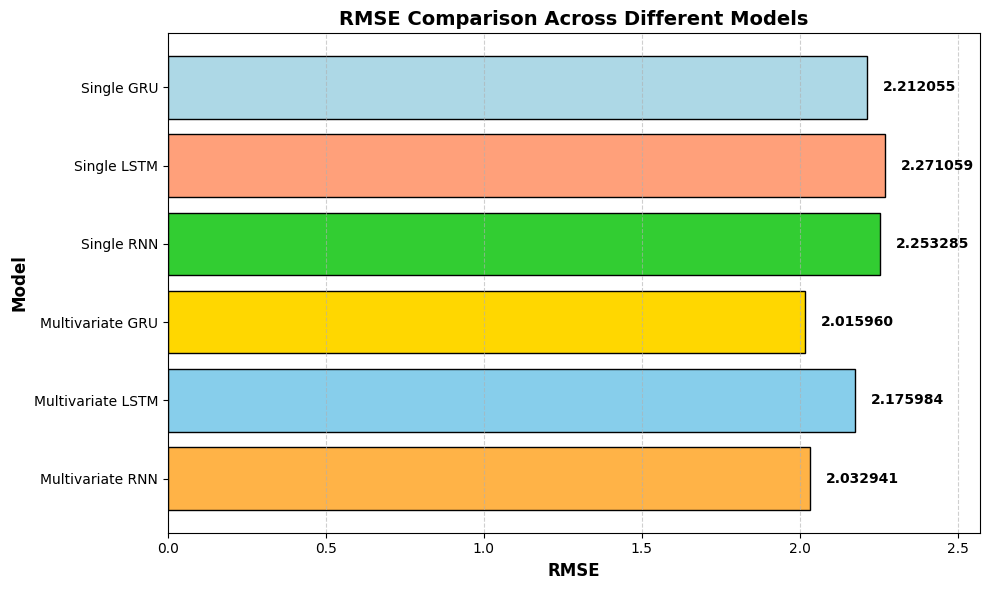

In [ ]:
import matplotlib.pyplot as plt

# Hardcoded RMSE values and model names
model_names = ["Multivariate RNN", "Multivariate LSTM", "Multivariate GRU", "Single RNN", "Single LSTM", "Single GRU"]
rmse_values = [rnn_model_multi_rmse, lstm_model_multi_rmse, gru_model_multi_rmse, rnn_rmse, lstm_rmse, gru_rmse]  

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust figure size
colors = ['#FFB347', '#87CEEB', '#FFD700', '#32CD32', '#FFA07A', '#ADD8E6']  # Bright color palette

plt.barh(model_names, rmse_values, color=colors, edgecolor='black')
plt.xlabel("RMSE", fontsize=12, fontweight='bold')
plt.ylabel("Model", fontsize=12, fontweight='bold')
plt.title("RMSE Comparison Across Different Models", fontweight='bold', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Adjust x-axis limits to give space for the RMSE values
plt.xlim(0, max(rmse_values) + 0.3)

# Display RMSE values next to the bars
for i, value in enumerate(rmse_values):
    plt.text(value + 0.05, i, f'{value:.6f}', va='center', ha='left', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()


### Hyperparameters for GRU

In [160]:
import torch
from torch.utils.data import DataLoader
import numpy as np


# Example ranges for grid search
lookback_values = [10, 20, 30]
hidden_dim_values = [32, 64, 128]

# Function to train and evaluate the model
def train_and_evaluate_model(lookback, hidden_dim, train_data, valid_data, seq_len):
    # Prepare datasets with the current lookback (seq_len)
    train_dataset = StockDataset(train_data, seq_len=seq_len)
    valid_dataset = StockDataset(valid_data, seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, generator=generator)
    valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

    # Initialize GRU model with the current hidden_dim
    model = GRU(input_dim=train_data.shape[1], hidden_dim=hidden_dim, output_dim=1).to(device)

    # Train and evaluate the model (adapt your train function to return validation RMSE)
    model, valid_rmse = train_and_evaluate(model, train_loader, valid_loader, device)

    return model, valid_rmse

# Dictionary to store RMSE results for each configuration
results = {}
best_model = None
best_rmse = float('inf')
best_config = None

# Grid search over lookback and hidden_dim
for lookback in lookback_values:
    for hidden_dim in hidden_dim_values:
        set_seed(42)
        print(f"Training model with lookback={lookback}, hidden_dim={hidden_dim}")

        # Train and evaluate the model for the current configuration
        model, valid_rmse = train_and_evaluate_model(lookback, hidden_dim, train_data, valid_data, seq_len=lookback)

        # Store the result
        results[(lookback, hidden_dim)] = valid_rmse
        print(f"Validation RMSE for lookback={lookback}, hidden_dim={hidden_dim}: {valid_rmse}")

        # Check if this model has the best RMSE so far
        if valid_rmse < best_rmse:
            best_rmse = valid_rmse
            best_model = model
            best_config = (lookback, hidden_dim)

# After the grid search, the best model is stored in `best_model`
print(f"Best configuration: Lookback={best_config[0]}, Hidden Dim={best_config[1]} with RMSE={best_rmse}")

Training model with lookback=10, hidden_dim=32
Epoch 1/100, Train Loss: 0.05726467063160319, Valid Loss: 0.0025757779309060424, RMSE: 7.623948097229004
Epoch 2/100, Train Loss: 0.005705469292527261, Valid Loss: 0.000413261610083282, RMSE: 2.9715917110443115
Epoch 3/100, Train Loss: 0.0004904424008839813, Valid Loss: 0.0005321000295225531, RMSE: 3.3224546909332275
Epoch 4/100, Train Loss: 0.00042669641047005395, Valid Loss: 0.0004876697086729109, RMSE: 3.186622142791748
Epoch 5/100, Train Loss: 0.00040592535821671943, Valid Loss: 0.0005242050741799176, RMSE: 3.2987136840820312
Epoch 6/100, Train Loss: 0.00038461424035056934, Valid Loss: 0.0005035296897403895, RMSE: 3.2315833568573
Epoch 7/100, Train Loss: 0.0003658599165838065, Valid Loss: 0.00044082787935622035, RMSE: 3.0387165546417236
Epoch 8/100, Train Loss: 0.00035125903837309266, Valid Loss: 0.0003830557863693684, RMSE: 2.8509521484375
Epoch 9/100, Train Loss: 0.00033939862968461395, Valid Loss: 0.000355491298250854, RMSE: 2.75366

In [161]:
print(results)

{(10, 32): 2.0836864, (10, 64): 2.1020467, (10, 128): 2.0503426, (20, 32): 1.9971173, (20, 64): 2.0611534, (20, 128): 1.9901645, (30, 32): 2.049674, (30, 64): 2.249584, (30, 128): 2.4685104}


In [162]:
# Find the best configuration based on validation RMSE
best_params = min(results, key=results.get)
best_rmse = results[best_params]
print(f"Best configuration: Lookback={best_params[0]}, Hidden Dim={best_params[1]} with RMSE={best_rmse}")

Best configuration: Lookback=20, Hidden Dim=128 with RMSE=1.9901645183563232


### Test the best model

Final Loss: 2.770002603530884, Final RMSE: 1.6643325090408325


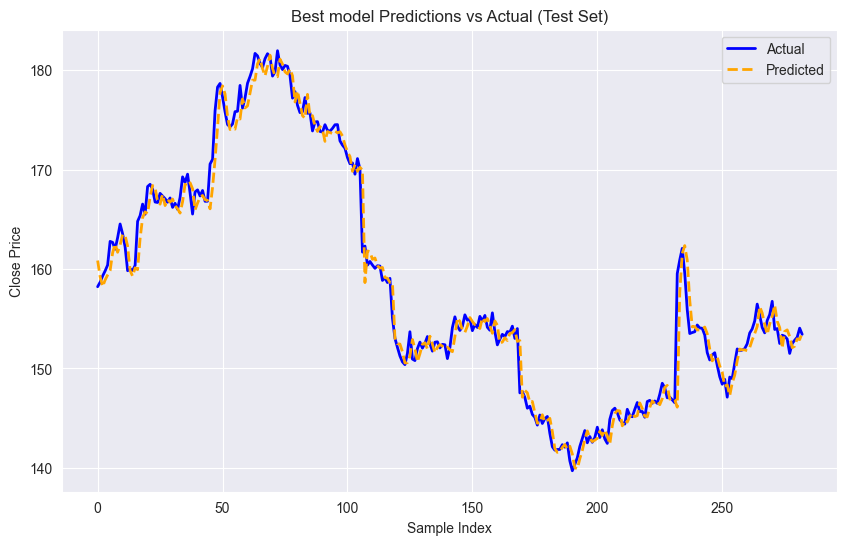

In [163]:
plot_predictions(best_model, test_loader, device, title="Best model Predictions vs Actual (Test Set)")

In [4]:
((2.2532849311828613 - 1.9901645183563232)/2.2532849311828613)*100


11.677192226569105

In [9]:
((5.0772929191589355 - 0.00017936305521288888*10000)/ 5.0772929191589355) * 100

64.67348682285584